# Factor Analysis 

In [21]:

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from IPython.display import display, clear_output
from matplotlib import animation, rc
from IPython.display import HTML
from sklearn.decomposition import FactorAnalysis, PCA, MiniBatchDictionaryLearning
import requests
import pickle, gzip, numpy

%matplotlib inline
#%matplotlib notebook
    
def plot_im_array2(X,S,N,A,title):    
    I = np.ones(((A*(1+S),A*(1+S))))*max(X.flatten())
    k=0
    for i in range(A):
        for j in range(A):
            I[i*(S)+i:(i+1)*S+i,j*S+j:(j+1)*S+j] = X[k,:].reshape((S, S))
            k=k+1
            if(k==N): break
        if(k==N): break
            
    plt.imshow(I, cmap=plt.cm.gray,interpolation=None)
    plt.colorbar()
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    

In [22]:
# Get Data
r = requests.get('https://s3.amazonaws.com/img-datasets/mnist.pkl.gz')
with open('mnist.pkl.gz', 'wb') as f:
    f.write(r.content)

In [23]:
#Load Data
f = gzip.open('mnist.pkl.gz', 'rb')
train_set, test_set = pickle.load(f,encoding='latin1')

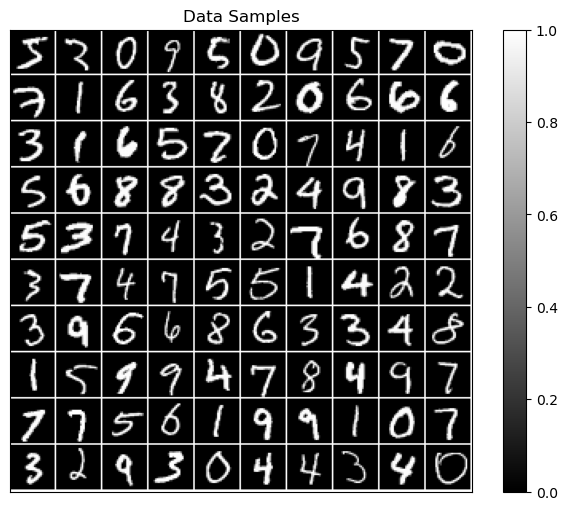

In [24]:
#Show data
X = train_set[0]/256.0
X = X.reshape(X.shape[0],X.shape[1]*X.shape[2])
plt.figure(figsize=[8,6]);
plot_im_array2(X[range(0,50000,500),:],28,100,10,"Data Samples")
plt.clim(0,1)
plt.show()

Y = train_set[1]

# Example Factor Analysis Tasks


## Generation

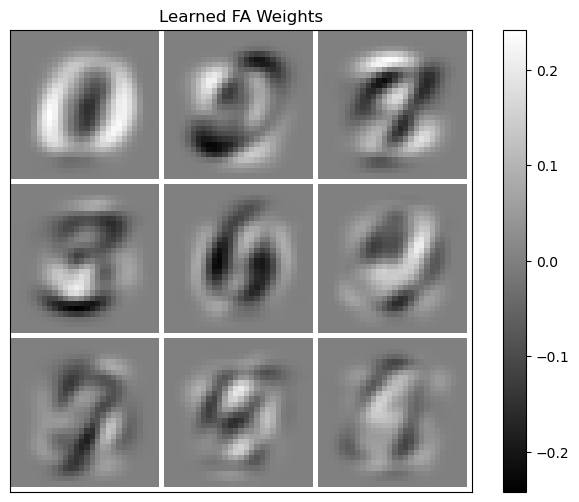

In [25]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

FA = FactorAnalysis(n_components=9, tol=0.01, copy=True, max_iter=100, random_state=0)
FA.fit(X[:10000,:])
Wfs=FA.components_
mus = FA.mean_

plt.figure(1,figsize=[8,6])
plot_im_array2(Wfs,28,9,3,"Learned FA Weights")
plt.show()

In [38]:
def generate(Z,W,mu):
    return(Z.dot(W) + mu)

def f(z1,z2,z3,z4,z5,z6,z7,z8,z9):
    z = np.array([z1,z2,z3,z4,z5,z6,z7,z8,z9])
    x = generate(z,Wfs,mus).reshape((28,28))
    plt.imshow(x,cmap=plt.cm.gray,interpolation=None,vmin=0,vmax=1)
    plt.colorbar()
    plt.show()

interact(f,z1=(-5.0,5.0),z2=(-5.0,5.0),z3=(-5.0,5.0),
           z4=(-5.0,5.0),z5=(-5.0,5.0),z6=(-5.0,5.0),
           z7=(-5.0,5.0),z8=(-5.0,5.0),z9=(-5.0,5.0),
         continuous_update=False)

interactive(children=(FloatSlider(value=0.0, description='z1', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…

<function __main__.f(z1, z2, z3, z4, z5, z6, z7, z8, z9)>

## Reconstruction

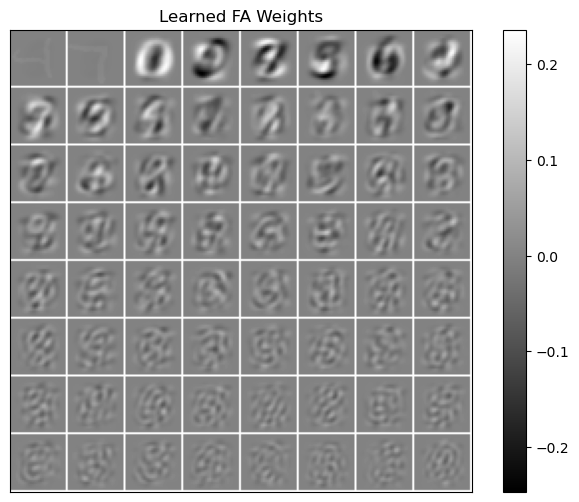

In [35]:
FAx = FactorAnalysis(n_components=64, tol=0.01, copy=True, max_iter=100, random_state=0)
FAx.fit(X[:5000,:])
Wfx=FAx.components_
mux = FAx.mean_

plt.figure(1,figsize=[8,6])
plot_im_array2(Wfx,28,64,8,"Learned FA Weights")
plt.show()

In [37]:
def reconstruct(Z,W,mu):
    return(Z.dot(W) + mu)

def f(noise_std=0):
    Xsub = X[range(0,50000,500),:]
    #Xsub = np.minimum(1,np.maximum(0,Xsub + noise_std*np.random.randn(*Xsub.shape)))
    Xsub = np.minimum(1,np.maximum(0,Xsub + noise_std*np.random.randn(*Xsub.shape)))

    Z    = FAx.transform(Xsub)
    XR   = reconstruct(Z,Wfx,mux)

    plt.figure(1,figsize=[16,4])
    plt.subplot(1,3,1)
    plot_im_array2(Xsub,28,100,10,"Data Samples")

    plt.subplot(1,3,2)
    plot_im_array2(XR,28,100,10,"Reconstructions")
    plt.clim(0,1)

    plt.subplot(1,3,3)
    plt.title("Codes")
    plt.imshow(Z,cmap=plt.get_cmap('seismic'),interpolation="nearest")
    plt.colorbar()
    plt.clim(-6,6)

interact(f,noise_std=(0.0,1.0),continuous_update=False)

interactive(children=(FloatSlider(value=0.0, description='noise_std', max=1.0), Output()), _dom_classes=('widg…

<function __main__.f(noise_std=0)>

## Dimensionality Reduction

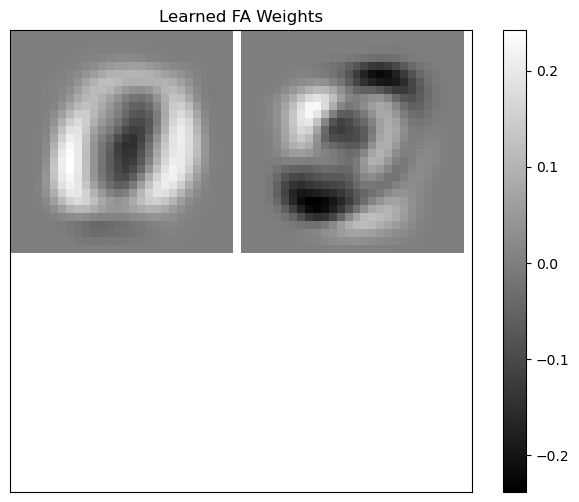

In [29]:
FA = FactorAnalysis(n_components=2, tol=0.01, copy=True, max_iter=100, random_state=0)
FA.fit(X[:5000,:])
Wf=FA.components_
mu = FA.mean_

plt.figure(1,figsize=[8,6])
plot_im_array2(Wf,28,2,2,"Learned FA Weights")
plt.show()

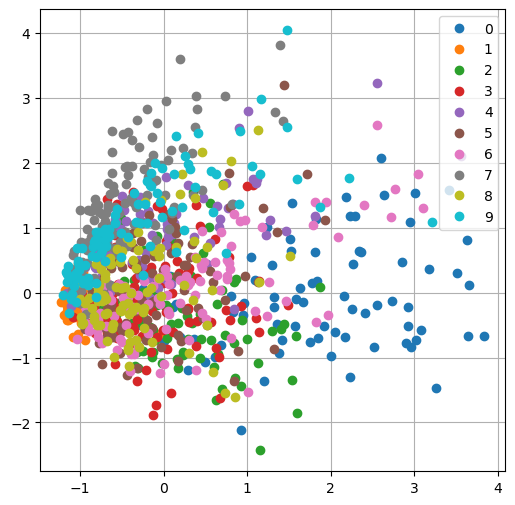

In [30]:
Xsub = X[range(0,50000,50),:]
Xsub = np.minimum(1,np.maximum(0,Xsub + noise_std*np.random.randn(*Xsub.shape)))

Z    = FA.transform(Xsub)

plt.figure(figsize=(6,6))
for i in range(10):
    plt.plot(Z[Y[range(0,50000,50)]==i,0],Z[Y[range(0,50000,50)]==i,1],'o',alpha=1)
    
plt.grid(True)
plt.legend(range(10))
plt.show()